In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler # Стандартизация функций путем удаления среднего 
                                                  # и масштабирования до единичной дисперсии
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.decomposition import PCA

%matplotlib inline

## Kobe Bryant  shot selection

Cсылка на соревнование: https://www.kaggle.com/c/kobe-bryant-shot-selection

Goal: Fun and education

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis. Practice got Kobe an eight-figure contract and 5 championship rings. What will it get you?

This data contains the location and circumstances of every field goal attempted by Kobe Bryant took during his 20-year career. Your task is to predict whether the basket went in (shot_made_flag).

We have removed 5000 of the shot_made_flags (represented as missing values in the csv file). These are the test set shots for which you must submit a prediction. You are provided a sample submission file with the correct shot_ids needed for a valid prediction.

In [2]:
data = pd.read_csv('kobe.csv')

In [3]:
# смотрим, в каких колонках есть пустые значения 
nan_values = data.isnull().sum().sort_values(ascending=False) 
nan_values

shot_made_flag        5000
action_type              0
shot_distance            0
opponent                 0
matchup                  0
game_date                0
team_name                0
team_id                  0
shot_zone_range          0
shot_zone_basic          0
shot_zone_area           0
shot_type                0
seconds_remaining        0
combined_shot_type       0
season                   0
playoffs                 0
period                   0
minutes_remaining        0
lon                      0
loc_y                    0
loc_x                    0
lat                      0
game_id                  0
game_event_id            0
shot_id                  0
dtype: int64

In [4]:
# изучаем список всех колонок 
print(data.columns)
data['shot_made_flag'].sample(10)

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id'],
      dtype='object')


24792    1.0
6817     NaN
4538     1.0
10524    0.0
28810    1.0
29875    0.0
6897     0.0
26820    1.0
25262    0.0
25311    1.0
Name: shot_made_flag, dtype: float64

In [5]:
# удалим строки в пустыми значениями? сбросив индекс
null_data = data[data['shot_made_flag'].notnull()].copy()
null_data.columns = (['action_type/Тип_действия',                                
                'combined_shot_type/комбинир.бросок',                                                         
                'game_event_id/id_события_игры',                
                'game_id/id_игры',                                
                'lat/широта',                                   
                'loc_x',  
                'loc_y',
                'lon',
                'minutes_remaining/осталось_минут',
                'period/период',
                'playoffs/плей-офф',                    # 0 и 1
                'season/сезон',                         # 2008-09 или 1997-98 и так далее
                'seconds_remaining/осталось_секунд',    # 
                'shot_distance/дистанция_броска',
                'shot_made_flag/попадание',             # 0 и 1
                'shot_type/тип_попадания',
                'shot_zone_area/зона_попадания',
                'shot_zone_basic',
                'shot_zone_range/диапазон_зоны_броска',
                'team_id/id_команды',
                'team_name/название_команды',
                'game_date/дата_игры',
                'matchup/совпадение',
                'opponent/противник',
                'shot_id/id_броска'])
null_data

,action_type/Тип_действия,combined_shot_type/комбинир.бросок,game_event_id/id_события_игры,game_id/id_игры,lat/широта,loc_x,loc_y,lon,minutes_remaining/осталось_минут,period/период,...,shot_type/тип_попадания,shot_zone_area/зона_попадания,shot_zone_basic,shot_zone_range/диапазон_зоны_броска,team_id/id_команды,team_name/название_команды,game_date/дата_игры,matchup/совпадение,opponent/противник,shot_id/id_броска
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,Driving Layup Shot,Layup,382,49900088,34.0443,0,0,-118.2698,7,4,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30692
30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,...,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693
30694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30695
30695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,...,3PT Field Goal,Center(C),Above the Break 3,24+ ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30696


In [6]:
target = 'shot_made_flag/попадание'

**Задания:**

1. Провести анализ данных. Много хороших примеров анализа можно посмотреть здесь https://www.kaggle.com/c/kobe-bryant-shot-selection/kernels
2. Подготовить фичи для обучения модели - нагенерить признаков, обработать пропущенные значения, проверить на возможные выбросы, обработать категориальные признаки и др.
3. Обучить линейную модель, Lasso, Ridge (с встроеной регуляризацией) на тех же признаках - построить сравнительную таблицу или график коэффициентов, сделать заключения о том, как меняется величина коэффициентов, какие зануляются. 

**Дополнительно**
4. Сравнить результаты на тестовом наборе данных - сделать train_test_split в самом начале, подготовить переменные, сравнить результаты работы классификаторов (те же 3), метрика ROC AUC
5. Построить PCA на подготовленных признаках, посмотреть, какие компоненты составляют наибольшую часть дисперсии целевой переменной

In [7]:
null_data['shot_made_flag/попадание'].sample(7)

print(null_data['shot_zone_range/диапазон_зоны_броска'].unique())

# столбец 'shot_zone_range/диапазон_зоны_броска' имеет 5 уникальных значений: 
# закодируем данные методом получения фиктивных признаков 
shot_zone_range = pd.get_dummies(null_data['shot_zone_range/диапазон_зоны_броска'])
shot_zone_range

['8-16 ft.' '16-24 ft.' 'Less Than 8 ft.' '24+ ft.' 'Back Court Shot']


,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1,0,0,1,0,0
2,1,0,0,0,0
3,1,0,0,0,0
4,0,0,0,0,1
5,0,0,1,0,0
...,...,...,...,...,...
30691,0,0,0,0,1
30692,0,0,0,0,1
30694,1,0,0,0,0
30695,0,1,0,0,0


In [8]:
# фактически мы видим, что можно убрать столбцы, которые не влияют на результат. К ним отнесем следующие:
# - 'team_id/id_команды',
# - 'team_name/название_команды',
# - 'matchup/совпадение'
dropped_columns = ['team_id/id_команды', 'team_name/название_команды', 'matchup/совпадение', 'shot_zone_range/диапазон_зоны_броска']
null_data.drop(dropped_columns, inplace=True, axis=1)


In [9]:
# Способы выбрать столбцы, кроме определенного:
# features_columns = [i for i in null_data.columns if i != 'shot_zone_range/диапазон_зоны_броска']
null_data

,action_type/Тип_действия,combined_shot_type/комбинир.бросок,game_event_id/id_события_игры,game_id/id_игры,lat/широта,loc_x,loc_y,lon,minutes_remaining/осталось_минут,period/период,...,season/сезон,seconds_remaining/осталось_секунд,shot_distance/дистанция_броска,shot_made_flag/попадание,shot_type/тип_попадания,shot_zone_area/зона_попадания,shot_zone_basic,game_date/дата_игры,opponent/противник,shot_id/id_броска
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,2000-10-31,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,2000-10-31,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,2000-10-31,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,2000-10-31,POR,5
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,2000-01,32,14,0.0,2PT Field Goal,Left Side(L),Mid-Range,2000-10-31,POR,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,Driving Layup Shot,Layup,382,49900088,34.0443,0,0,-118.2698,7,4,...,1999-00,4,0,0.0,2PT Field Goal,Center(C),Restricted Area,2000-06-19,IND,30692
30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,...,1999-00,5,4,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),2000-06-19,IND,30693
30694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,...,1999-00,28,21,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,2000-06-19,IND,30695
30695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,...,1999-00,10,26,0.0,3PT Field Goal,Center(C),Above the Break 3,2000-06-19,IND,30696


In [10]:
# объединим столбцы в датафрейм
df = pd.concat((null_data, shot_zone_range), axis=1)
df

,action_type/Тип_действия,combined_shot_type/комбинир.бросок,game_event_id/id_события_игры,game_id/id_игры,lat/широта,loc_x,loc_y,lon,minutes_remaining/осталось_минут,period/период,...,shot_zone_area/зона_попадания,shot_zone_basic,game_date/дата_игры,opponent/противник,shot_id/id_броска,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,Left Side(L),Mid-Range,2000-10-31,POR,2,0,0,1,0,0
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,Left Side Center(LC),Mid-Range,2000-10-31,POR,3,1,0,0,0,0
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,Right Side Center(RC),Mid-Range,2000-10-31,POR,4,1,0,0,0,0
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,Center(C),Restricted Area,2000-10-31,POR,5,0,0,0,0,1
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,Left Side(L),Mid-Range,2000-10-31,POR,6,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,Driving Layup Shot,Layup,382,49900088,34.0443,0,0,-118.2698,7,4,...,Center(C),Restricted Area,2000-06-19,IND,30692,0,0,0,0,1
30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,...,Center(C),In The Paint (Non-RA),2000-06-19,IND,30693,0,0,0,0,1
30694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,...,Left Side Center(LC),Mid-Range,2000-06-19,IND,30695,1,0,0,0,0
30695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,...,Center(C),Above the Break 3,2000-06-19,IND,30696,0,1,0,0,0


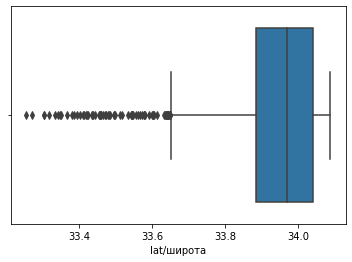

In [11]:
# поищем выбросы по широте бросков lat 
# вначале попробуем визуализировать признак: видим, что он содержит довольно много аномалных значений - 
# они лежат за пределами первого квартиля (примерно ниже значений 33,65)
sns.boxplot(df['lat/широта'])

In [12]:
# обработаем выбросы 
# это можно делать различными методами, например, с помощью кластеризации DBSCAN либо изолирующего леса 
# outlier_detection = DBSCAN(min_samples = 2, eps = 3)
# clusters = outlier_detection.fit_predict(df['lat/широта'] )
# list(clusters).count(-1)

# Применим метод IQR
q1 = df['lat/широта'].quantile(0.25)
q3 = df['lat/широта'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - (1.5 * iqr) 
upper_bound = q3 + (1.5 * iqr)
remove_outliers = df[df['lat/широта'].between(lower_bound, upper_bound, inclusive=True)]
remove_outliers

,action_type/Тип_действия,combined_shot_type/комбинир.бросок,game_event_id/id_события_игры,game_id/id_игры,lat/широта,loc_x,loc_y,lon,minutes_remaining/осталось_минут,period/период,...,shot_zone_area/зона_попадания,shot_zone_basic,game_date/дата_игры,opponent/противник,shot_id/id_броска,16-24 ft.,24+ ft.,8-16 ft.,Back Court Shot,Less Than 8 ft.
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,Left Side(L),Mid-Range,2000-10-31,POR,2,0,0,1,0,0
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,Left Side Center(LC),Mid-Range,2000-10-31,POR,3,1,0,0,0,0
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,Right Side Center(RC),Mid-Range,2000-10-31,POR,4,1,0,0,0,0
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,Center(C),Restricted Area,2000-10-31,POR,5,0,0,0,0,1
5,Jump Shot,Jump Shot,244,20000012,34.0553,-145,-11,-118.4148,9,3,...,Left Side(L),Mid-Range,2000-10-31,POR,6,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30691,Driving Layup Shot,Layup,382,49900088,34.0443,0,0,-118.2698,7,4,...,Center(C),Restricted Area,2000-06-19,IND,30692,0,0,0,0,1
30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,...,Center(C),In The Paint (Non-RA),2000-06-19,IND,30693,0,0,0,0,1
30694,Running Jump Shot,Jump Shot,426,49900088,33.8783,-134,166,-118.4038,3,4,...,Left Side Center(LC),Mid-Range,2000-06-19,IND,30695,1,0,0,0,0
30695,Jump Shot,Jump Shot,448,49900088,33.7773,31,267,-118.2388,2,4,...,Center(C),Above the Break 3,2000-06-19,IND,30696,0,1,0,0,0


In [13]:
lower_bound

33.6503

In [14]:
# сравнивая количество строк в таблице до удаления выбросов и после, видим, что их не столь много (76 строк с аномалиями)
# выведем их на экран 
anomalies = []
for outlier in df['lat/широта']:
        if outlier > upper_bound or outlier < lower_bound:
            anomalies.append(outlier)
print(anomalies)

[33.5673, 33.6353, 33.5783, 33.4243, 33.3483, 33.4563, 33.4833, 33.6123, 33.4953, 33.6483, 33.5433, 33.3933, 33.6483, 33.6483, 33.5773, 33.4183, 33.6333, 33.4953, 33.5433, 33.3803, 33.5443, 33.4363, 33.5163, 33.4423, 33.5723, 33.3033, 33.6383, 33.3423, 33.6433, 33.4593, 33.4113, 33.4653, 33.6463, 33.6413, 33.6383, 33.4343, 33.5613, 33.5113, 33.6003, 33.3033, 33.4723, 33.6393, 33.4003, 33.5333, 33.6393, 33.4783, 33.6443, 33.4803, 33.3473, 33.6043, 33.5413, 33.5543, 33.4973, 33.6483, 33.4703, 33.5433, 33.6413, 33.6013, 33.4593, 33.4533, 33.6443, 33.5793, 33.3863, 33.4333, 33.3333, 33.5443, 33.2713, 33.4103, 33.6033, 33.2533, 33.3163, 33.4213, 33.5903, 33.4553, 33.5473, 33.3653]


In [15]:
# продолжим готовить данные для обучения модели 
# преобразуем категориалные переменные в "горячие" векторы.
# воспользуемся той же самой функцией Pandas - pd.get_dummies 

# образоабатем столбцы:
cat_feat = list(df.dtypes[df.dtypes == object].index)
len(cat_feat)

8

In [16]:
# Смотрим сколько у нас значений по каждому категориальному признаку:
# видимо, что по ряду признаков их довольно много (33, 55 и даже 1558). 
# ограничим их количество 
cat_nunique = df[cat_feat].nunique()                       # nunique() возвращает количество уникальных объектов
print(cat_nunique)

action_type/Тип_действия                55
combined_shot_type/комбинир.бросок       6
season/сезон                            20
shot_type/тип_попадания                  2
shot_zone_area/зона_попадания            6
shot_zone_basic                          7
game_date/дата_игры                   1558
opponent/противник                      33
dtype: int64


In [17]:
#Чтобы в разы не увеличивать число признаков при построении dummy,
#будем использовать категориальные признаки с < 21 уникальных значений
cat_feat_ = list(cat_nunique[cat_nunique < 21].index)

In [18]:
# Разбиваем на train/test
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in splitter.split(df, df[target]):
    d_train = df.iloc[train_index]
    d_test = df.iloc[test_index]
    
    y_train = df[target].iloc[train_index]
    y_test = df[target].iloc[test_index]

In [19]:
# Создаем дамми-переменные для категорий
dummy_train = pd.get_dummies(d_train[cat_feat_], columns=cat_feat_)  # преобразовываем категориальную переменную 
dummy_test = pd.get_dummies(d_test[cat_feat_], columns=cat_feat_)    # в фиктивные / индикаторные переменные

dummy_cols = list(set(dummy_train) & set(dummy_test))           # список уникальных (set) колонок категориальных признаков

dummy_train_q = dummy_train[dummy_cols]                         # обучающийся сет категориальных признаков 
dummy_test_q = dummy_test[dummy_cols]                           # тестовый сет категориальных признаков

In [20]:
# определим численные признаки
num_feat = [f for f in df if f not in (cat_feat + ['game_event_id/id_события_игры', 'game_id/id_игры', 'shot_made_flag/попадание'])]
num_feat

['lat/широта',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining/осталось_минут',
 'period/период',
 'playoffs/плей-офф',
 'seconds_remaining/осталось_секунд',
 'shot_distance/дистанция_броска',
 'shot_id/id_броска',
 '16-24 ft.',
 '24+ ft.',
 '8-16 ft.',
 'Back Court Shot',
 'Less Than 8 ft.']

In [21]:
X_train = pd.concat([d_train[num_feat],
                     dummy_train_q], axis=1)

X_test = pd.concat([d_test[num_feat],
                     dummy_test_q], axis=1)

In [22]:
# обучим модель методом Lasso 
clf = linear_model.Lasso(alpha=0, random_state=43)
clf.fit(X_train, y_train)

C:\Users\zlatt\anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\zlatt\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\zlatt\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2356.1706136133207, tolerance: 0.507969158923968
  positive)


Lasso(alpha=0, copy_X=True, fit_intercept=True, max_iter=1000, normalize=False,
      positive=False, precompute=False, random_state=43, selection='cyclic',
      tol=0.0001, warm_start=False)

In [23]:
# исследвуем качество полученной модели: низкое
clf.score(X_test, y_test)

0.06840405354750767

In [24]:
clf.predict(X_test)

array([0.36074299, 0.17127768, 0.40301769, ..., 0.42413649, 0.33960545,
       0.575599  ])

In [25]:
# получим коэффициенты модели
print('Коэффициенты: ', clf.coef_)
print('Смещение (свободный член): ', clf.intercept_)

Коэффициенты:  [ 4.47868725e-02 -8.23746929e-05 -1.26678755e-06 -1.23858432e-05
  2.48570305e-03 -1.21230739e-02 -6.74861176e-03  6.34161091e-04
 -5.93433725e-03  1.85951073e-07  8.87737736e-02 -5.64500732e-02
  8.99329684e-02 -2.00746878e-01 -2.74837682e-02  4.01793196e-04
  3.12331195e-01 -1.22886406e-01  1.50926135e-02  2.02631455e-02
  1.93097304e-02  1.63980849e-02  2.60366594e-02 -2.06626234e-02
  4.64314235e-02  1.16496826e-02 -3.24876752e-02 -1.79643663e-03
 -7.87363349e-02  2.70580210e-02  1.41619837e-02 -2.62536114e-02
  1.22999798e-02  9.15510557e-02  4.60318282e-01 -3.82375596e-02
  8.79756565e-03 -2.94660360e-02  6.98236154e-02  1.18146962e-02
 -1.70593400e-02  5.25875751e-02  1.56926062e-02  2.36700438e-02
  6.12346687e-02 -5.20771110e-02 -5.28655507e-02 -9.40746455e-03
 -1.38371013e-02 -5.42382688e-02 -3.48263430e-03 -1.99261377e-02
  1.11972317e-01  1.08789927e-02 -7.48822262e-02 -2.92347499e-02]
Смещение (свободный член):  -1.0115940313987317


In [27]:
# Построим иную модель 
clf_ = Ridge(alpha=0, random_state=43)
clf_.fit(X_train, y_train)

Ridge(alpha=0, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=43, solver='auto', tol=0.001)

In [30]:
# исследвуем качество полученной модели: низкое. Оно близко к скорингу предыдущего метода
clf_.score(X_test, y_test)

0.06828258426313316

In [51]:
# мы применили метод линейного моделирования системы. Возможно о линейной зависимости говорить не приходится
# Это может влиять на качество прогнозирования
# Другой вариант повышения качества предсказаний - заново поработать с признаками
# Может быть, есть смысл применить PCA

# n_components int, float или 'mle', по умолчанию = None
# Количество компонентов, которые необходимо оставить. Если n_components не установлен, все компоненты сохраняются:
# n_components == min(n_samples, n_features)
# MLE Минки используется, чтобы угадать размер.

pca = PCA(n_components=39)

In [52]:
pca.fit(X_train, y_train)

PCA(copy=True, iterated_power='auto', n_components=39, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [53]:
pca.score(X_test, y_test)

0.7292697154770915

In [54]:
# это кажется слишком простым рецептом, однако формально мы видим:
# снижение размерности с 56-ти до 39-ти признаков дало нам более высокое качество модели 
X_train.shape

(20557, 56)